# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between spectra. 

We'll first explore 1D OT on gaussians followed by 1D OT on pure sine waves. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* Quantile method   
* Entropic barycenter 
* Regularized sinkhorn

In [1]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

## OT between gaussians

In this part we compute 1D Optimal transport between two gaussian distributions.


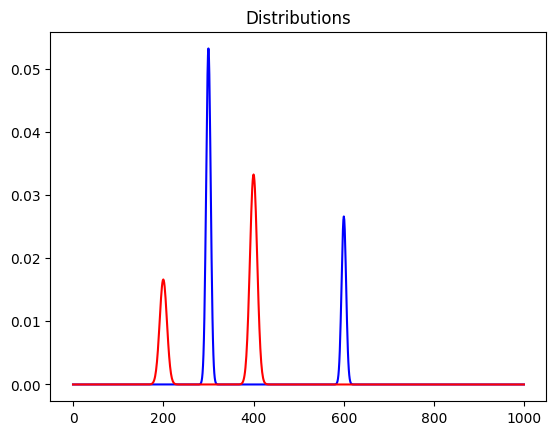

In [13]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 1000
x = np.arange(n, dtype=np.float64)

f1 = n * 0.3
f2 = n * 0.2
s1 = n * 0.005
s2 = n * 0.008

# Gaussian distributions
a1 = 1.0 * ot.datasets.make_1D_gauss(n, m=f1, s=s1) + 0.5 * ot.datasets.make_1D_gauss(n, m=f1*2, s=s1)
a1 = a1 / np.sum(a1)
a2 = 0.5 * ot.datasets.make_1D_gauss(n, m=f2, s=s2) + 1.0 * ot.datasets.make_1D_gauss(n, m=f2*2, s=s2)
a2 = a2 / np.sum(a2)

fig, ax = plt.subplots()
ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.set_title('Distributions')

plt.show()


In [47]:
# Optimal transport

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.empirical_sinkhorn
reg = 1e-2
X_s = a1.reshape(n, 1)
X_t = a2.reshape(n, 1)
bary_pot = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)


/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/ot/backend.py:1082: RuntimeWarning: divide by zero encountered in log
  return np.log(a)


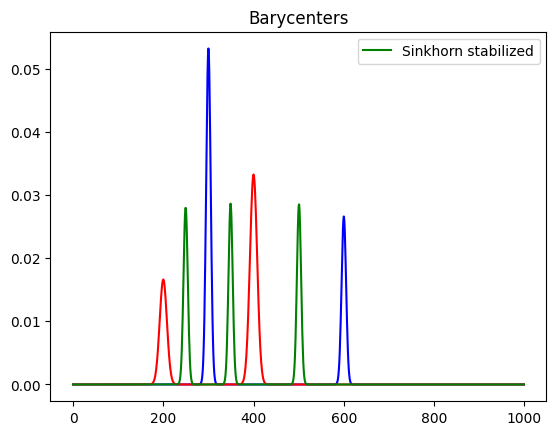

In [53]:
barycenter = np.zeros(n)
for i in range(n):
    for j in range(n):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

fig, ax = plt.subplots()

ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.plot(x, barycenter, color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a dirac

In [83]:
# Optimal transport

f11 = 300
f12= f11*2
a1 = np.zeros(n)
a1[f11] = 1
a1[f12] = 0.5
a1 /= np.sum(a1)

f21 = 200
f22= f21*2
a2 = np.zeros(n)
a2[f21] = 0.5
a2[f22] = 1
a2 /= np.sum(a2)

M = ot.utils.dist0(n)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.empirical_sinkhorn
reg = 1e-2
X_s = a1.reshape(n, 1)
X_t = a2.reshape(n, 1)
bary_pot = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)


/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/ot/backend.py:1082: RuntimeWarning: divide by zero encountered in log
  return np.log(a)


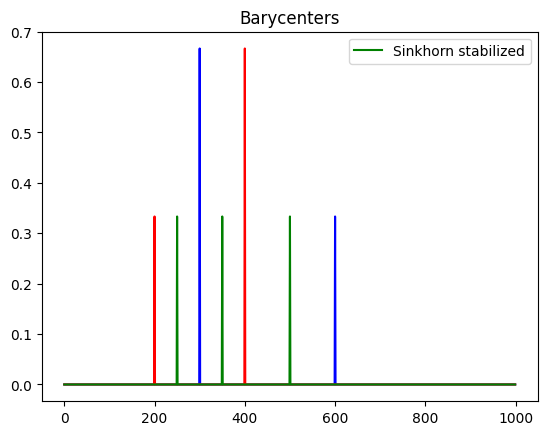

In [84]:
barycenter = np.zeros(n)
for i in range(n):
    for j in range(n):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

barycenter /= np.sum(barycenter)

fig, ax = plt.subplots()

ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.plot(x, barycenter, color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a signal

In [86]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.5
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A4_freq = 440
A4_signal = np.sin(2 * np.pi * A4_freq * frames)
A4_signal[:smooth_len] *= smoothing
A4_signal[-smooth_len:] *= np.flip(smoothing)

C5_freq = 1046.5
C5_signal = np.sin(2 * np.pi * C5_freq * frames)
C5_signal[:smooth_len] *= smoothing
C5_signal[-smooth_len:] *= np.flip(smoothing)


In [97]:
A4_fft = np.abs(np.fft.fft(A4_signal)) / len(frames)
freq = np.fft.fftfreq(len(frames), d=1/sr)
freq[220]


440.0

In [106]:
# Optimal transport

dur = 1000

A4_fft = np.abs(np.fft.fft(A4_signal))
A4_fft=A4_fft[:dur]
A4_fft /= np.sum(A4_fft)
C5_fft = np.abs(np.fft.fft(C5_signal)) / len(frames)
C5_fft=C5_fft[:dur]
C5_fft /= np.sum(C5_fft)

M = ot.utils.dist0(dur)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.empirical_sinkhorn
reg = 1e-2
bary_pot = ot.bregman.sinkhorn_stabilized(A4_fft, C5_fft, M, reg)


/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/ot/bregman.py:1150: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


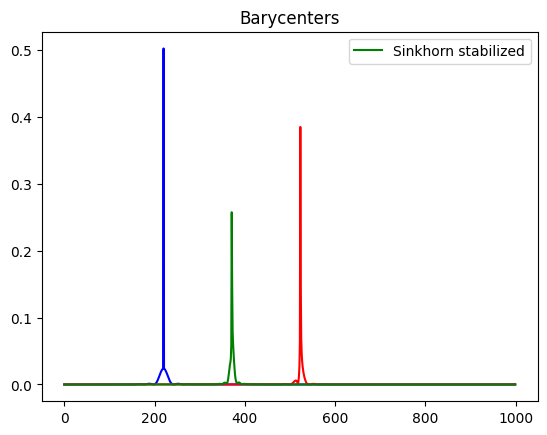

In [107]:
barycenter = np.zeros(dur)
for i in range(n):
    for j in range(n):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

barycenter /= np.sum(barycenter)

fig, ax = plt.subplots()

ax.plot(x, A4_fft, color="blue")
ax.plot(x, C5_fft, color="red")
ax.plot(x, barycenter, color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a real signal

In [116]:
duration = 0.3 # in seconds

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)


A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


In [132]:
# Optimal transport
dur = len(A_signal) # 11 min

A4_fft = np.abs(np.fft.fft(A_signal))
A4_fft=A4_fft[:dur]
A4_fft /= np.sum(A4_fft)
C5_fft = np.abs(np.fft.fft(C_signal)) / len(frames)
C5_fft=C5_fft[:dur]
C5_fft /= np.sum(C5_fft)


M = ot.utils.dist0(dur)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.empirical_sinkhorn
reg = 1e-2
bary_pot = ot.bregman.sinkhorn_stabilized(A4_fft, C5_fft, M, reg)


/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/ot/bregman.py:1150: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


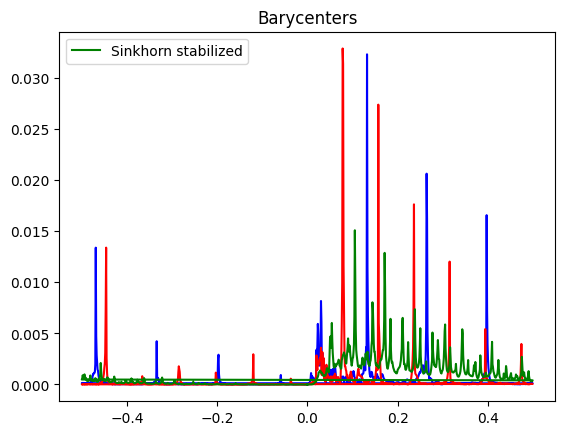

In [139]:
dur = 1000

barycenter = np.zeros(dur)
for i in range(dur):
    for j in range(dur):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

barycenter /= np.sum(barycenter)

fig, ax = plt.subplots()

freq = np.fft.fftfreq(dur)


ax.plot(freq, A4_fft[:1000], color="blue")
ax.plot(freq, C5_fft[:1000], color="red")
ax.plot(freq, barycenter, color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


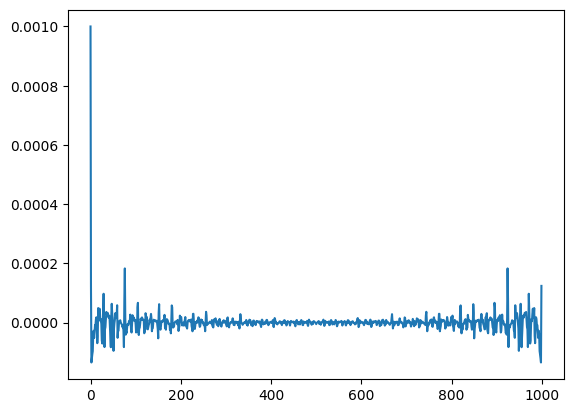

In [140]:
inversed = np.fft.ifft(barycenter)
plt.plot(inversed)

In [141]:

audio_widgets = []

title = widgets.Label(f'A4')
audio_player = IPython.display.Audio(data=A_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C5')
audio_player = IPython.display.Audio(data=C_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation')
audio_player = IPython.display.Audio(data=inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

/Users/soudanichourouk/Personal/memoire/audio_ot/.venv/lib/python3.9/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
